In [1]:
import os
import sys
os.environ['PATH']+=':'+sys.path[1].split('lib')[0]+'bin'
sys.path.append('/home/diego/Projects')

import tqdm
import tempfile
import numpy as np
import matplotlib.pyplot as plt

import simtk.openmm as openmm
import simtk.unit as unit
import simtk.openmm.app as app
from openmmtools import states, mcmc
from yank.multistate import ParallelTemperingSampler, MultiStateReporter, ParallelTemperingAnalyzer

import TestSystems

plt.style.use("ggplot")

## Info

### Sources:
This script has been prepared taking https://github.com/choderalab/gibbs/blob/master/openmm/python/parallel-tempering.py and https://github.com/choderalab/gibbs/blob/master/openmm/python/parallel-tempering.py from J. Chodera's lab.

https://github.com/choderalab/yank/blob/master/Yank/multistate/replicaexchange.py

# Setting up de mpi comm world and platforms to be used

In [2]:
# List of available platforms printed out to choose
list_platforms=False
# printing out platform names
if list_platforms:
    for ii in range(openmm.Platform.getNumPlatforms()):
        print(openmm.Platform.getPlatform(ii).getName())

In [3]:
platform_name = 'CUDA'
platform = openmm.Platform.getPlatformByName(platform_name)

In [4]:
from mpi4py import MPI # MPI wrapper
hostname = os.uname()[1]
ngpus = 1
comm = MPI.COMM_WORLD
deviceid = comm.rank % ngpus

In [5]:
platform.setPropertyDefaultValue('CudaDeviceIndex', '%d' % deviceid)

In [6]:
print ("node '%s' deviceid %d / %d, MPI rank %d / %d" % (hostname, deviceid, ngpus, comm.rank, comm.size))

node 'ixtlilton' deviceid 0 / 1, MPI rank 0 / 1


In [7]:
# seeds must be different in each device
seed = np.random.randint(2**32 - comm.size) + comm.rank
np.random.seed(seed)

# Setting up the system

In [8]:
working_system = TestSystems.TrpCageImplicit()
positions = working_system.positions

# Setting up the experiment variables

In [9]:
experiment_continuation= False
minimize = True # minimize
equilibrate = True # equilibrate

# minimization
tolerance = 1.0 * unit.kilocalories_per_mole / unit.nanometer
maximum_evaluations = 5000

# equilibration
collision_rate = 5.0 / unit.picosecond #Langevin
timestep_equilibration = 1.0 * unit.femtoseconds
nequiliterations = 100
nsteps_equilibration = 10000

# parallel tempering
n_replicas = 6
T_min      = 298.0*unit.kelvin
T_max      = 600.0*unit.kelvin
timestep = 2.0 * unit.femtoseconds # timestep for simulation   
nsteps = 50 # number of timesteps per iteration (exchange attempt)
niterations = 1000 # number of iterations


# Setting up the reporter

In [10]:
# Include case experiment continuation
storage_path = tempfile.NamedTemporaryFile(delete=False).name + '.nc'
reporter = MultiStateReporter(storage_path, checkpoint_interval=10)

# Minimization

In [11]:
if minimize and not experiment_continuation:
    # Create integrator and context.
    integrator = openmm.VerletIntegrator(timestep)    
    context = openmm.Context(working_system.system, integrator, platform)
    # Set positions.
    context.setPositions(working_system.positions)
    init_state = context.getState(getEnergy=True)
    # Eval init potential energy
    print ("Potential Energy before minimization: %16.3f kcal/mol" % ((init_state.getPotentialEnergy() / unit.kilocalories_per_mole)))
    # Minimize.        
    openmm.LocalEnergyMinimizer.minimize(context, tolerance, maximum_evaluations)
    # Store final coordinates and update system positions
    minimized_state = context.getState(getPositions=True, getEnergy=True)
    positions = minimized_state.getPositions(asNumpy=True)
    # Eval final potential energy
    print ("Potential Energy after minimization: %16.3f kcal/mol" % ((minimized_state.getPotentialEnergy() / unit.kilocalories_per_mole)))
    # Clean up.
    del context
    del integrator
    del init_state
    del minimized_state

Potential Energy before minimization:         -668.575 kcal/mol
Potential Energy after minimization:         -718.455 kcal/mol


# Equilibration

100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


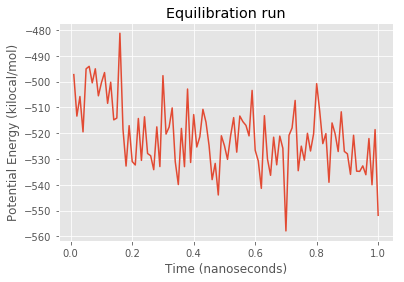

In [12]:
if True and not experiment_continuation:
    integrator = openmm.LangevinIntegrator(T_min, collision_rate, timestep_equilibration)    
    context = openmm.Context(working_system.system, integrator, platform)
    context.setPositions(positions)
    equil_energies = np.zeros((nequiliterations),dtype=float)
    equil_times    = np.zeros((nequiliterations),dtype=float)
    for iteration in tqdm.tqdm(range(nequiliterations)):
        integrator.step(nsteps_equilibration)
        state = context.getState(getEnergy=True)
        equil_energies[iteration] = state.getPotentialEnergy() / unit.kilocalories_per_mole
        equil_times[iteration] = state.getTime() / unit.nanosecond
    equilibrated_state = context.getState(getPositions=True)
    positions = equilibrated_state.getPositions(asNumpy=True)
    del context
    del integrator
    del state
    del equilibrated_state
    plt.plot(equil_times,equil_energies)
    plt.title("Equilibration run")
    plt.xlabel("Time (nanoseconds)")
    plt.ylabel("Potential Energy (kilocal/mol)")

# Parallel Tempering initialization

In [13]:
reference_state = states.ThermodynamicState(system=working_system.system, temperature=T_min)

In [14]:
move = mcmc.GHMCMove(timestep=timestep, n_steps=nsteps)

In [15]:
simulation = ParallelTemperingSampler(mcmc_moves=move, number_of_iterations=niterations)

In [16]:
simulation.create(reference_state, states.SamplerState(positions), reporter,
                  min_temperature=T_min, max_temperature=T_max, n_temperatures=n_replicas)

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

In [17]:
simulation.platform=platform
simulation.comm=comm

In [18]:
simulation.options

{'replica_mixing_scheme': 'swap-all',
 'number_of_iterations': 1000,
 'online_analysis_interval': None,
 'online_analysis_target_error': 0.2,
 'online_analysis_minimum_iterations': 50,
 'locality': None}

In [19]:
for ii,jj in simulation.options.items():
    print(ii,jj)

print('number of iterations',simulation.number_of_iterations)
print('number of replicas',simulation.n_replicas)
print('number of states',simulation.n_states)

replica_mixing_scheme swap-all
number_of_iterations 1000
online_analysis_interval None
online_analysis_target_error 0.2
online_analysis_minimum_iterations 50
locality None
number of iterations 1000
number of replicas 6
number of states 6


In [20]:
simulation.run() #sera posible poner tqdm en las replicas?

In [21]:
simulation.iteration

1000

In [22]:
analysis=ParallelTemperingAnalyzer(reporter)

In [23]:
analysis.generate_mixing_statistics()

MixingStatistics(transition_matrix=array([[0.67371938, 0.27394209, 0.04955457, 0.00278396, 0.        ,
        0.        ],
       [0.27394209, 0.49888641, 0.18986637, 0.03619154, 0.00111359,
        0.        ],
       [0.04955457, 0.18986637, 0.56347439, 0.18429844, 0.01280624,
        0.        ],
       [0.00278396, 0.03619154, 0.18429844, 0.6091314 , 0.15757238,
        0.01002227],
       [0.        , 0.00111359, 0.01280624, 0.15757238, 0.67928731,
        0.14922049],
       [0.        , 0.        , 0.        , 0.01002227, 0.14922049,
        0.84075724]]), eigenvalues=array([1.        , 0.93116548, 0.75065018, 0.56541059, 0.38252598,
       0.23550389]), statistical_inefficiency=237.50749206349224)

In [24]:
os.remove(storage_path)

### TODO
- cómo saco las temperaturas de las replicas?